训练集类别分布：
类别 0: 24985 张
类别 1: 30896 张
类别 2: 46332 张


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:61: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/50] - Train Loss: 0.8338, Train Acc: 65.75% | Val Loss: 0.8042, Val Acc: 67.57%
 保存新的最优模型 (Val Acc: 67.57%)
Epoch [2/50] - Train Loss: 0.7611, Train Acc: 71.22% | Val Loss: 0.7884, Val Acc: 68.71%
 保存新的最优模型 (Val Acc: 68.71%)
Epoch [3/50] - Train Loss: 0.7366, Train Acc: 73.03% | Val Loss: 0.7674, Val Acc: 71.13%
 保存新的最优模型 (Val Acc: 71.13%)
Epoch [4/50] - Train Loss: 0.7170, Train Acc: 74.33% | Val Loss: 0.7668, Val Acc: 70.79%
Epoch [5/50] - Train Loss: 0.7063, Train Acc: 75.13% | Val Loss: 0.7798, Val Acc: 69.34%
Epoch [6/50] - Train Loss: 0.6953, Train Acc: 75.76% | Val Loss: 0.7819, Val Acc: 68.96%
Epoch [7/50] - Train Loss: 0.6491, Train Acc: 78.86% | Val Loss: 0.7347, Val Acc: 72.55%
 保存新的最优模型 (Val Acc: 72.55%)
Epoch [8/50] - Train Loss: 0.6317, Train Acc: 80.01% | Val Loss: 0.7471, Val Acc: 72.15%
Epoch [9/50] - Train Loss: 0.6185, Train Acc: 80.89% | Val Loss: 0.7315, Val Acc: 73.53%
 保存新的最优模型 (Val Acc: 73.53%)
Epoch [10/50] - Train Loss: 0.6092, Train Acc: 81.47% | Val

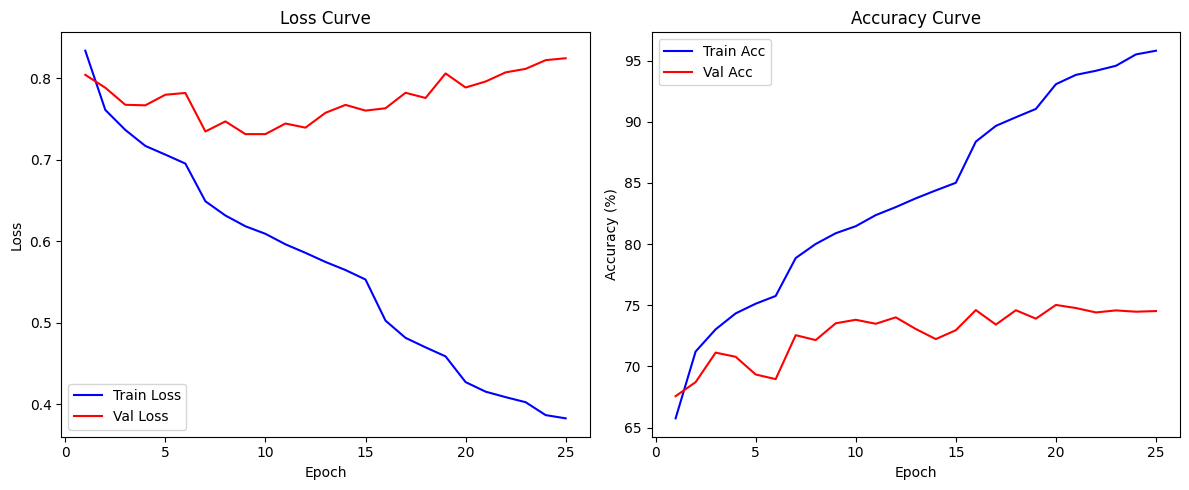

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torch.utils.data import DataLoader
from torchvision import transforms
from collections import Counter
import matplotlib.pyplot as plt
import os
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from dataset import StoneDataset  

# 1. 设置超参数
batch_size = 128
learning_rate = 0.001
num_epochs = 50
patience = 5  # early stopping的容忍次数
save_path = './best_model.pth'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 2. 数据处理
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize((0.4603, 0.4554, 0.4505), (0.1706, 0.1727, 0.1814))
])

dataset_train = StoneDataset(root="./dataset_processed", split="train", transforms=transform)
dataset_val = StoneDataset(root="./dataset_processed", split="val", transforms=transform)

train_loader = DataLoader(
    dataset_train,
    batch_size=512,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
    persistent_workers=True
)

val_loader = DataLoader(
    dataset_val,
    batch_size=512,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
    persistent_workers=True
)

# 打印类别分布
label_counter = Counter(dataset_train.labels)
print("训练集类别分布：")
for label, count in label_counter.items():
    print(f"类别 {label}: {count} 张")

# 3. 构建模型
def build_efficientnet(num_classes=3):
    weights = EfficientNet_B0_Weights.DEFAULT
    model = efficientnet_b0(weights=weights)
    # 替换分类层
    in_features = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(in_features, num_classes)
    return model
    
model = build_efficientnet(num_classes=3).to(device)

if torch.cuda.device_count() > 1:
    print(f"使用 {torch.cuda.device_count()} 张GPU进行训练！")
    model = nn.DataParallel(model)

model = model.to(device)

# 4. 损失函数和优化器
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)

# 加上 ReduceLROnPlateau scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='max',
    factor=0.5,
    patience=2,
    min_lr=1e-6,
    verbose=True
)

# 5. 训练 & 验证过程
best_val_acc = 0.0
early_stop_counter = 0

train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = 100. * correct / total

    # 验证
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_loss = val_loss / len(val_loader)
    val_acc = 100. * correct / total

    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    
    scheduler.step(val_acc)
    # 保存最好的模型
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        if isinstance(model, nn.DataParallel):
            torch.save(model.module.state_dict(), save_path)
        else:
            torch.save(model.state_dict(), save_path)
        print(f" 保存新的最优模型 (Val Acc: {val_acc:.2f}%)")
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print(" Early Stopping triggered.")
            break

# 6. 绘制 Loss 和 Accuracy 曲线
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(epochs, train_losses, 'b-', label='Train Loss')
plt.plot(epochs, val_losses, 'r-', label='Val Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, train_accs, 'b-', label='Train Acc')
plt.plot(epochs, val_accs, 'r-', label='Val Acc')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()
